# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')
display(data.head())
data.info()
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d')
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 no

# UPD_0_start:

In [3]:
def data_info(data):
    print(50*'-')
    data.info()
    print('Описание количественных переменных')
    print(data.describe(percentiles=[.25, .5]))
    print(50*'-')
    print(f'Количество дубликатов в таблице = {data.duplicated().sum()}')

In [4]:
data_info(data)

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB
Описание количественных переменных
            

In [5]:
data.NumberOfPictures.value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

# Замечания после первичного анализа данных:

<b>Пропуски:</b>
    - VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired.
<b>Анализ численных данных на адекватность:</b>
    - Price = 0. Удалим эти строки, так как цена быть должна;
    - Power, 20000 лс слишком много. Но для этого нужно более детально понимание о мощностях всех моделей автомобилей, т.к. есть двигатели двс мощностью свыше 100.000 лс;
    - Kilometer, медиана совпадает с max, что странно;
    - RegistrationMonth [1, 12], т.е. 0 быть не должно;
    - NumberOfPictures везде = 0. По-моему значимость данного признака нулевая, т.е. фичу вовсе можно удалить.
<b>Анализ остальных колонок:</b>
    - признаки DateCrawled, DateCreated, LastSeen не будут использоваться, т.к. не несут никакой полезной информации.

Так же на первой стадии выявлено 4 дубликата.

Алгоритм обработки данных:

- удалить колонку с числом изображений (NumberOfPictures);
- изменить типы данных на Date;
- проработать выбросы, NaN значения и дубликаты.

In [6]:
#удалим параметр с числом фото (NumberOfPictures)
data = data.drop('NumberOfPictures', axis = 1)
display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19,87439,2016-04-07 07:15:26


данные с типом datetime

In [7]:
#функция высчитывает % данных по условию
def part_of_value(df1, df):
    return df1.shape[0]/df.shape[0]*100

Таргер признак <b>Price</b>

4416.656775846645

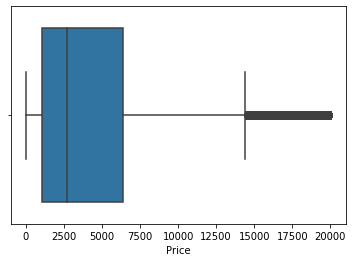

In [8]:
sns.boxplot(x = data['Price'])
data.Price.mean()

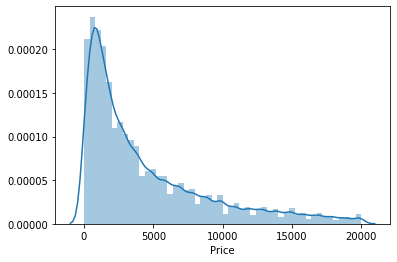

In [9]:
sns.distplot(data['Price'])

Как уже было описано выше - будем удалять значения target признака, которые равны нулю, так как цена не может быть равной нулю.

In [10]:
data[data['Price'] <= 100]['Price'].count()/data.shape[0]*100

4.048040319553911

3.4% подобных данных не так много, поэтому удаляем.

In [11]:
data = data.drop(data.query('Price<=100').index)
data.shape

(340024, 15)

# UPD_0_end:

In [12]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [13]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          32251
RegistrationYear         0
Gearbox              16085
Power                    0
Model                16889
Kilometer                0
RegistrationMonth        0
FuelType             28004
Brand                    0
NotRepaired          63867
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

<b>Пропуска найдены в следующих фичах:</b>

- VehicleType — тип автомобильного кузова

- Gearbox — тип коробки передач

- Model — модель автомобиля

- FuelType — тип топлива

- NotRepaired — была машина в ремонте или нет


In [14]:
def visual_df_nulls(df):
    print('{:^52}{:^16}{:^20}'.format('Признак', 'Всего пропусков', 'Пропусков (%)'))
    for col in df.columns:
        missed_data_share = df[col].isnull().mean()*100
        missed_data_count = df[col].isnull().sum()
        print('{:^50}{:^14}{:^18.5f}'.format(col, missed_data_count, missed_data_share))

visual_df_nulls(data)
print()


                      Признак                       Всего пропусков    Пропусков (%)    
                   DateCrawled                          0            0.00000      
                      Price                             0            0.00000      
                   VehicleType                        32251          9.48492      
                 RegistrationYear                       0            0.00000      
                     Gearbox                          16085          4.73055      
                      Power                             0            0.00000      
                      Model                           16889          4.96700      
                    Kilometer                           0            0.00000      
                RegistrationMonth                       0            0.00000      
                     FuelType                         28004          8.23589      
                      Brand                             0            0.00000     

In [15]:
data['VehicleType'] = data['VehicleType'].fillna('other_VehicleType')
data['Gearbox'] = data['Gearbox'].fillna('other_Gearbox')
data['Model'] = data['Model'].fillna('other_Model')
data['FuelType'] = data['FuelType'].fillna('other_FuelType')
data['NotRepaired'] = data['NotRepaired'].fillna('other_NotRepaired')
print(data.isna().sum())
display(data.head())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other_VehicleType,1993,manual,0,golf,150000,0,petrol,volkswagen,other_NotRepaired,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other_Model,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other_NotRepaired,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [16]:
#data['Model'].value_counts().count()

In [17]:
#data['Brand'].value_counts().count()

In [18]:
'''
print(pd.get_dummies(data['VehicleType'], drop_first=False).head())
print(pd.get_dummies(data['Gearbox'], drop_first=False).head())
print(pd.get_dummies(data['Model'], drop_first=False).head())
print(pd.get_dummies(data['FuelType'], drop_first=False).head())
print(pd.get_dummies(data['Brand'], drop_first=False).head())
print(pd.get_dummies(data['NotRepaired'], drop_first=False).head())
'''

"\nprint(pd.get_dummies(data['VehicleType'], drop_first=False).head())\nprint(pd.get_dummies(data['Gearbox'], drop_first=False).head())\nprint(pd.get_dummies(data['Model'], drop_first=False).head())\nprint(pd.get_dummies(data['FuelType'], drop_first=False).head())\nprint(pd.get_dummies(data['Brand'], drop_first=False).head())\nprint(pd.get_dummies(data['NotRepaired'], drop_first=False).head())\n"

In [19]:
'''
def code_myohe(data, feature):
    for i in data[feature].unique():
        data[feature + '=' + i] = (data[feature] == i).astype(float)
code_myohe(data, 'VehicleType')
code_myohe(data, 'Gearbox')
code_myohe(data, 'Model')
code_myohe(data, 'FuelType')
code_myohe(data, 'Brand')
code_myohe(data, 'NotRepaired')
display(data.head())
'''

"\ndef code_myohe(data, feature):\n    for i in data[feature].unique():\n        data[feature + '=' + i] = (data[feature] == i).astype(float)\ncode_myohe(data, 'VehicleType')\ncode_myohe(data, 'Gearbox')\ncode_myohe(data, 'Model')\ncode_myohe(data, 'FuelType')\ncode_myohe(data, 'Brand')\ncode_myohe(data, 'NotRepaired')\ndisplay(data.head())\n"

<div class="alert alert-info">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Круто, но зачем изобретать велосипед?)
</div>

In [20]:
'''
data = data.drop(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], axis = 1)
display(data.head())
'''

"\ndata = data.drop(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], axis = 1)\ndisplay(data.head())\n"

In [21]:
'''
X = data.drop(['Price'], axis = 1)
y = data['Price']
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=12345)
'''

"\nX = data.drop(['Price'], axis = 1)\ny = data['Price']\nfeatures_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=12345)\n"

<b>UPD_0:</b> в данном случае решил применить LabelEncoder вместо OHE.

In [22]:
VT_index = data.query('VehicleType==VehicleType')['VehicleType'].index

Gearbox_index = data.query('Gearbox==Gearbox')['Gearbox'].index

Model_index = data.query('Model==Model')['Model'].index

FuelType_index = data.query('FuelType==FuelType')['FuelType'].index

Brand_index = data.query('Brand==Brand')['Brand'].index

NotRepaired_index = data.query('NotRepaired==NotRepaired')['NotRepaired'].index

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [24]:
data.loc[VT_index, 'VehicleType'] = le.fit_transform(data.loc[VT_index, 'VehicleType'])

data.loc[Gearbox_index, 'Gearbox'] = le.fit_transform(data.loc[Gearbox_index, 'Gearbox'])

data.loc[Model_index, 'Model'] = le.fit_transform(data.loc[Model_index, 'Model'])

data.loc[FuelType_index, 'FuelType'] = le.fit_transform(data.loc[FuelType_index, 'FuelType'])

data.loc[Brand_index, 'Brand'] = le.fit_transform(data.loc[Brand_index, 'Brand'])

data.loc[NotRepaired_index, 'NotRepaired'] = le.fit_transform(data.loc[NotRepaired_index, 'NotRepaired'])

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,4,1993,1,0,116,150000,0,7,38,1,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,2,2011,1,190,167,125000,5,2,1,2,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,7,2004,0,163,117,125000,8,2,14,1,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,6,2001,1,75,116,150000,6,7,38,0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,6,2008,1,69,101,90000,7,2,31,0,2016-03-31,60437,2016-04-06 10:17:21


In [25]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis = 1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,4,1993,1,0,116,150000,0,7,38,1,70435
1,18300,2,2011,1,190,167,125000,5,2,1,2,66954
2,9800,7,2004,0,163,117,125000,8,2,14,1,90480
3,1500,6,2001,1,75,116,150000,6,7,38,0,91074
4,3600,6,2008,1,69,101,90000,7,2,31,0,60437


<b>Работа с выбросами</b>

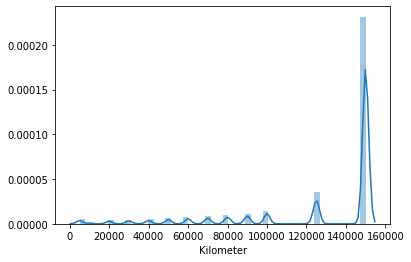

In [26]:
sns.distplot(data.Kilometer)

Максимальный пробег около 150000 км. Возможно тот, кто выгружал нам эти данные так ограничивал, поэтому трогать не будем.

In [27]:
part_of_value(df1=data.query('RegistrationMonth==0'), df=data)

9.170235042232314

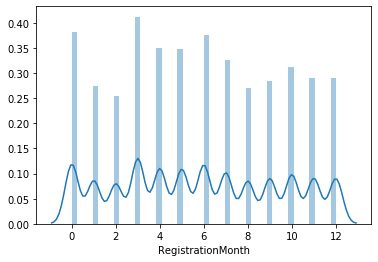

In [28]:
sns.distplot(data.RegistrationMonth)

In [29]:
data.query('RegistrationMonth==0').shape[0]

31181

In [30]:
frac_list = []
for i in range(1,13):
    frac = data.query('RegistrationMonth==@i').shape[0]/(data.shape[0]-data.query('RegistrationMonth==0').shape[0])
    n_size = round(data.query('RegistrationMonth==0').shape[0]*frac)
    frac_list.append(n_size)

In [31]:
tmp = sum(frac_list)-data.query('RegistrationMonth==0').shape[0]

tmp

0

In [32]:
all_idx = np.array(data.query('RegistrationMonth==0').index)
for month, i in enumerate(frac_list):
    idx = np.random.choice(all_idx, size = i, replace = False)
    data.loc[idx, 'RegistrationMonth'] = (month+1)
    all_idx = all_idx[~np.isin(all_idx, idx)]

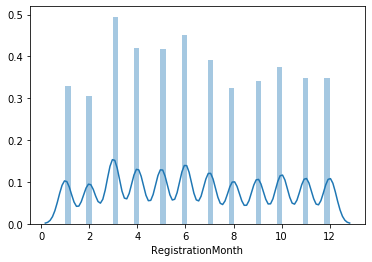

In [33]:
sns.distplot(data.RegistrationMonth)

In [34]:
part_of_value(df1 = data.query('RegistrationMonth==0'), df = data)

0.0

На данном этапе мы перераспределили значения параметра RegistrationMonth, которые равнялись нулю.

In [35]:
data_info(data)

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 340024 entries, 0 to 354368
Data columns (total 12 columns):
Price                340024 non-null int64
VehicleType          340024 non-null int64
RegistrationYear     340024 non-null int64
Gearbox              340024 non-null int64
Power                340024 non-null int64
Model                340024 non-null int64
Kilometer            340024 non-null int64
RegistrationMonth    340024 non-null int64
FuelType             340024 non-null int64
Brand                340024 non-null int64
NotRepaired          340024 non-null int64
PostalCode           340024 non-null int64
dtypes: int64(12)
memory usage: 43.7 MB
Описание количественных переменных
               Price    VehicleType  RegistrationYear        Gearbox  \
count  340024.000000  340024.000000     340024.000000  340024.000000   
mean     4602.471902       4.956638       2003.976778       0.857260   
std      4514.902742       2.36

<b>Промежуточные итоги:</b>

- удалили чуть больше 4% данных
- в конце получилось слишком много дубликатов, но это просто совпадение данных, поэтому ничего с этим делать не будем, оставим и будем двигаться дальше.

## Обучение моделей

In [36]:
'''
from sklearn.metrics import r2_score

class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                w = w - self.step_size * gradient
        self.w = w[1:]
        self.w0 = w[0]
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

model = SGDLinearRegression(0.01, 10, 100)
model.fit(features_train, target_train)
pred_train = model.predict(features_train)
pred_test = model.predict(features_test)
print(r2_score(target_train, pred_train).round(5))
print(r2_score(target_test, pred_test).round(5))
'''

'\nfrom sklearn.metrics import r2_score\n\nclass SGDLinearRegression:\n    def __init__(self, step_size, epochs, batch_size):\n        self.step_size = step_size\n        self.epochs = epochs\n        self.batch_size = batch_size\n    def fit(self, train_features, train_target):\n        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        \n        y = train_target\n        w = np.zeros(X.shape[1])\n        for _ in range(self.epochs):\n            batches_count = X.shape[0] // self.batch_size\n            for i in range(batches_count):\n                begin = i * self.batch_size\n                end = (i + 1) * self.batch_size\n                X_batch = X[begin:end, :]\n                y_batch = y[begin:end]\n                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]\n                w = w - self.step_size * gradient\n        self.w = w[1:]\n        self.w0 = w[0]\n    def predict(self, test_features):\n        ret

In [37]:
X = data.drop(['Price'], axis = 1)
y = data['Price']
features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=12345)

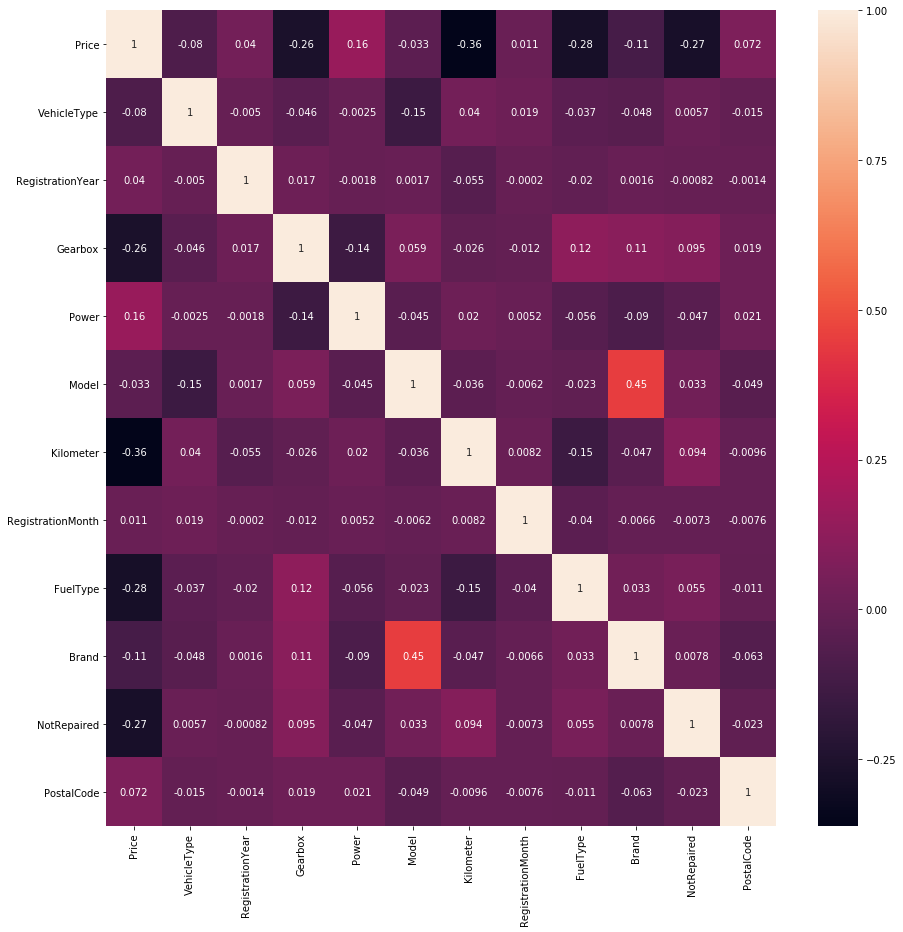

In [38]:
plt.figure(figsize = (15, 15))
sns.heatmap(data.corr(), annot = True)

count    340024.000000
mean       4602.471902
std        4514.902742
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

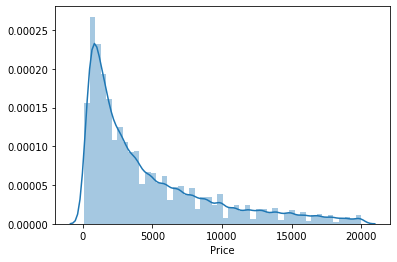

In [39]:
sns.distplot(y)
y.describe()

In [40]:
def learn_time(model, x_train, y_train):
    start = time.time()
    model.fit(x_train, y_train)
    end = time.time()
    time_fit = end - start
    return time_fit, model

In [41]:
def predict_time(model, x_test):
    start = time.time()
    predict = model.predict(x_test)
    end = time.time()
    time_predict = end - start
    return time_predict, predict

In [42]:
data_result = pd.DataFrame(columns = ['RMSE', 'Fit time', 'Predict time', 'Model'])
data_result

,RMSE,Fit time,Predict time,Model


In [43]:
def data_metrics(RMSE, l_time, p_time, model_name, df):
    df.loc[model_name, 'RMSE'] = RMSE
    df.loc[model_name, 'Fit time'] = l_time
    df.loc[model_name, 'Predict time'] = p_time
    df.loc[model_name, 'Model'] = model_name
    return df

Здесь мы выполним настройку моделей, но не будем изменять гиперпараметры, чтобы не нарушать чистоту эксперимента.

<b>Линейная регрессия</b>

In [44]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
import time
LR_learn_time, LR_model = learn_time(LinearRegression(), features_train, target_train)
LR_pred_time, LR_predict = predict_time(LR_model, features_test)
LR_RMSE = np.sqrt(mean_squared_error(target_test, LR_predict))
data_metrics(LR_RMSE, LR_learn_time, LR_pred_time, 'LinearRegression', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression


<b>L_2 (ridge)</b>

In [45]:
L2_time, L2_model = learn_time(Ridge(alpha=1, random_state=12345), features_train, target_train)
L2_pred_time, L2_predict = predict_time(L2_model, features_test)
L2_RMSE = np.sqrt(mean_squared_error(target_test, L2_predict))
data_metrics(L2_RMSE, L2_time, L2_pred_time, 'RidgeRegression', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression


<b>L_1 (lasso):</b>

In [46]:
L1_time, L1_model = learn_time(Lasso(alpha=0.5, random_state=12345), features_train, target_train)
L1_pred_time, L1_predict = predict_time(L1_model, features_test)
L1_RMSE = np.sqrt(mean_squared_error(target_test, L1_predict))
data_metrics(L1_RMSE, L1_time, L1_pred_time, 'LassoRegression', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression


Линейные модели отработали практически идентично.

<b>DecisionTree:</b>

In [47]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
tree_l_time, tree_model = learn_time(DecisionTreeRegressor(), features_train, target_train)
tree_pred_time, tree_predict = predict_time(tree_model, features_test)
tree_RMSE = np.sqrt(mean_squared_error(target_test, tree_predict))
data_metrics(tree_RMSE, tree_l_time, tree_pred_time, 'DecisionTree', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree


DecisionTree обучается лучше, но время обучения выросло.

<b>Randfom Forest</b>

In [48]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
RF_l_time, RF_model = learn_time(RandomForestRegressor(n_estimators=20, random_state=12345), features_train, target_train)
RF_pred_time, RF_predict = predict_time(RF_model, features_test)
RF_RMSE = np.sqrt(mean_squared_error(target_test, RF_predict))
data_metrics(RF_RMSE, RF_l_time, RF_pred_time, 'RandomForest', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest


<b>Gradient Boosting Regressor</b>

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
GBR_l_time, GBR_model = learn_time(GradientBoostingRegressor(n_estimators=100, random_state=12345), features_train, target_train)
GBR_pred_time, GBR_predict = predict_time(GBR_model, features_test)
GBR_RMSE = np.sqrt(mean_squared_error(target_test, GBR_predict))
data_metrics(GBR_RMSE, GBR_l_time, GBR_pred_time, 'GBR', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest
GBR,1986.04,23.5681,0.173019,GBR


<b>Light GBM</b>

In [50]:
from lightgbm import LGBMRegressor
LGB_l_time, LGB_model = learn_time(LGBMRegressor(random_state=12345), features_train, target_train)
LGB_pred_time, LGB_predict = predict_time(LGB_model, features_test)
LGB_RMSE = np.sqrt(mean_squared_error(target_test, LGB_predict))
data_metrics(LGB_RMSE, LGB_l_time, LGB_pred_time, 'LightGBM', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest
GBR,1986.04,23.5681,0.173019,GBR
LightGBM,1753.24,191.881,1.00007,LightGBM


<b>XGBoost</b>

In [51]:
import xgboost as xgb
XGBR_l_time, XGBR_model = learn_time(xgb.XGBRegressor(n_estimators = 100, random_state= 12345), features_train, target_train)
XGBR_pred_time, XGBR_predict = predict_time(XGBR_model, features_test)
XGBR_RMSE = np.sqrt(mean_squared_error(target_test, XGBR_predict))
data_metrics(XGBR_RMSE, XGBR_l_time, XGBR_pred_time, 'XGBR', data_result)

[14:44:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest
GBR,1986.04,23.5681,0.173019,GBR
LightGBM,1753.24,191.881,1.00007,LightGBM
XGBR,1991.13,20.1004,0.381386,XGBR


<b>CatBoost</b>

In [52]:
from catboost import CatBoostRegressor, Pool
CAT_l_time, CAT_model = learn_time(CatBoostRegressor(loss_function='RMSE', n_estimators = 100, random_state= 12345), features_train, target_train)
CAT_pred_time, CAT_predict = predict_time(CAT_model, features_test)
CAT_RMSE = np.sqrt(mean_squared_error(target_test, CAT_predict))
data_metrics(CAT_RMSE, CAT_l_time, CAT_pred_time, 'CatBoost', data_result)

0:	learn: 4426.9050237	total: 213ms	remaining: 21.1s
1:	learn: 4342.4584662	total: 412ms	remaining: 20.2s
2:	learn: 4264.3005839	total: 612ms	remaining: 19.8s
3:	learn: 4188.7516160	total: 811ms	remaining: 19.5s
4:	learn: 4115.8068146	total: 1.01s	remaining: 19.2s
5:	learn: 4043.5397422	total: 1.21s	remaining: 18.9s
6:	learn: 3972.5390610	total: 1.41s	remaining: 18.7s
7:	learn: 3907.9699055	total: 1.52s	remaining: 17.5s
8:	learn: 3846.3504942	total: 1.72s	remaining: 17.4s
9:	learn: 3786.5019307	total: 1.92s	remaining: 17.2s
10:	learn: 3727.1030113	total: 2.11s	remaining: 17.1s
11:	learn: 3668.6011179	total: 2.31s	remaining: 16.9s
12:	learn: 3611.9125109	total: 2.5s	remaining: 16.8s
13:	learn: 3556.6520201	total: 2.7s	remaining: 16.6s
14:	learn: 3506.5992895	total: 2.9s	remaining: 16.4s
15:	learn: 3456.9839350	total: 3.1s	remaining: 16.3s
16:	learn: 3409.7423955	total: 3.3s	remaining: 16.1s
17:	learn: 3363.0764253	total: 3.5s	remaining: 15.9s
18:	learn: 3318.0799892	total: 3.61s	remaini

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest
GBR,1986.04,23.5681,0.173019,GBR
LightGBM,1753.24,191.881,1.00007,LightGBM
XGBR,1991.13,20.1004,0.381386,XGBR
CatBoost,2152.63,20.89,0.0119691,CatBoost


<b>Базовая модель(const)</b>

In [53]:
y_hat = y.copy()
y_hat.loc[:] = y.mean()
y_hat.head()

0    4602.471902
1    4602.471902
2    4602.471902
3    4602.471902
4    4602.471902
Name: Price, dtype: float64

In [54]:
const_RMSE = np.sqrt(mean_squared_error(y, y_hat))
data_metrics(const_RMSE, 0, 0, 'Base', data_result)

,RMSE,Fit time,Predict time,Model
LinearRegression,3594.09,0.0990396,0.00491452,LinearRegression
RidgeRegression,3594.09,0.0384407,0.00340366,RidgeRegression
LassoRegression,3594.08,0.304237,0.207404,LassoRegression
DecisionTree,2192.96,2.61483,0.0641139,DecisionTree
RandomForest,1639.67,34.6453,1.161,RandomForest
GBR,1986.04,23.5681,0.173019,GBR
LightGBM,1753.24,191.881,1.00007,LightGBM
XGBR,1991.13,20.1004,0.381386,XGBR
CatBoost,2152.63,20.89,0.0119691,CatBoost
Base,4514.9,0,0,Base


<b>Итог:</b>

- все модели работают лучше базовой, что хорошо;
- очевидно, что сложные модели с набором простых моделей внутри работают дольше;
- видно, что лучший результат, за наименьшее количество времени обучения выдала модель LightGBM, а если поиграться с гиперпараметрами, то модель станет ещё эффективнее.

## Анализ моделей

In [ ]:
aa = None
bb = 0
for depth in range(1,11):
    tree = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    tree.fit(features_train, target_train)
    pred = tree.predict(features_test)
    RMSE_DT = np.sqrt(mean_squared_error(target_test, pred))
    if RMSE_DT > bb:
        aa = tree
        bb = RMSE_DT
        depth_1 = depth
print('RMSE DecisionTree модели c глубиной', depth_1, 'равна:', RMSE_DT)

In [55]:
features_train_1, features_other_1, target_train_1, target_other_1 = train_test_split(X, y, test_size=0.4, random_state=12345)
features_valid_1, features_test_1, target_valid_1, target_test_1 = train_test_split(features_other_1, target_other_1, test_size=0.5, random_state=12345)

In [56]:
for depth in range(1, 11):
    model_1_1 = DecisionTreeRegressor(random_state = 12345, max_depth = depth)# < создайте модель, указав max_depth=depth >

    model_1_1.fit(features_train_1, target_train_1)# < обучите модель >

    predictions_valid = model_1_1.predict(features_valid_1)# < найдите предсказания на валидационной выборке >

    print("max_depth =", depth, ": ", end='')
    print(np.sqrt(mean_squared_error(target_valid_1, predictions_valid))) 

max_depth = 1 : 3781.0256285099417
max_depth = 2 : 3275.4765036145377
max_depth = 3 : 2983.135787841864
max_depth = 4 : 2690.7506300589444
max_depth = 5 : 2485.8997248367136
max_depth = 6 : 2344.6144968453077
max_depth = 7 : 2243.708387749551
max_depth = 8 : 2154.57974981485
max_depth = 9 : 2088.167455800784
max_depth = 10 : 2041.7616155202031


In [57]:
for depth in range(1, 51):
    model_1_1 = DecisionTreeRegressor(random_state = 12345, max_depth = depth)# < создайте модель, указав max_depth=depth >

    model_1_1.fit(features_train_1, target_train_1)# < обучите модель >

    predictions_valid = model_1_1.predict(features_valid_1)# < найдите предсказания на валидационной выборке >

    print("max_depth =", depth, ": ", end='')
    print(np.sqrt(mean_squared_error(target_valid_1, predictions_valid))) 

max_depth = 1 : 3781.0256285099417
max_depth = 2 : 3275.4765036145377
max_depth = 3 : 2983.135787841864
max_depth = 4 : 2690.7506300589444
max_depth = 5 : 2485.8997248367136
max_depth = 6 : 2344.6144968453077
max_depth = 7 : 2243.708387749551
max_depth = 8 : 2154.57974981485
max_depth = 9 : 2088.167455800784
max_depth = 10 : 2041.7616155202031
max_depth = 11 : 2021.0670025894358
max_depth = 12 : 2004.0179239338681
max_depth = 13 : 1995.9983629268404
max_depth = 14 : 1994.976465907081
max_depth = 15 : 2019.9594869142984
max_depth = 16 : 2045.1296668193331
max_depth = 17 : 2092.329111534275
max_depth = 18 : 2117.8580293473087
max_depth = 19 : 2147.770258717513
max_depth = 20 : 2166.023120766906
max_depth = 21 : 2183.8029340324465
max_depth = 22 : 2193.376343101932
max_depth = 23 : 2210.860971344232
max_depth = 24 : 2213.7284152267225
max_depth = 25 : 2230.275638607922
max_depth = 26 : 2227.0459323208647
max_depth = 27 : 2228.0990703835973
max_depth = 28 : 2236.0154142076776
max_depth = 2

В данном случае лучший гиперпараметр max_depth = 14

In [62]:
model_1_1 = DecisionTreeRegressor(random_state = 12345, max_depth = 14)# < создайте модель, указав max_depth=depth >

model_1_1.fit(features_train_1, target_train_1)# < обучите модель >

predictions_test = model_1_1.predict(features_test_1)# < найдите предсказания на валидационной выборке >
print('RMSE:', np.sqrt(mean_squared_error(target_test_1, predictions_test)))

RMSE: 1987.16855658858


<b>Итог:</b> модель действительно обучилась немного лучше при глубине равной 14.